# ABSTRACT

### The journal "Housing Price Prediction with Improved Machine Learning Techniques" has worked on house prices in Beijing city, China. That paper has predicted house prices with not only ensemble methods but also other modern techniques like Hybrid and Stacked Generalization. We will replicate their work to make a case for future work like predicting UK housing prices. 

# 1. INTRODUCTION

### In recent years, due to the growing trend towards Big Data, machine learning has become a vital prediction approach because it can predict house prices more accurately based on their attributes, regardless of the data from previous years. Several studies explored this problem and proved the capability of the machine learning approach. However, most of them compared the models’ performance but did not consider the combination of different machine learning models such as Hybrid regression and Stacked Generalizaiton.

# 2. METHODOLOGY

## 2.1 Data Preprocessing

### We will use the Beijing dataset (taken from Kaggle) comprised of ten years from 2008 to 2018. It has 318851 rows (data) with 26 features. Each feature represents specific information related to housing.

### To work on the data, we have selected Python Language and fetch all the relevant libraries or modules, related to reading the data, finding missing values, exploratory analysis, model designing, and model evaluation.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Data Processing 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) 
simplefilter(action='ignore', category=UserWarning) 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Satistical Testing
from scipy import stats

# Converting Categorical to Numerical Finite Values
from sklearn.preprocessing import LabelEncoder

# Model Designing and Evaluation
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
import xgboost as xgb
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/lianjia/new.csv


In [2]:
# Reading the Data
df =  pd.read_csv('/kaggle/input/lianjia/new.csv',encoding='gbk',low_memory=False)#, errors='ignore')
# Shape of the Data
print ('DATA',df.shape)
df.head(1)

DATA (318851, 26)


,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.01952,1111027376244,2016-08-09,1464.0,106,415.0,31680,131.0,2,1,1,1,高 26,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0


In [3]:
# Columns or Features or Variables
df.columns

Index(['url', 'id', 'Lng', 'Lat', 'Cid', 'tradeTime', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'floor', 'buildingType', 'constructionTime',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district', 'communityAverage'],
      dtype='object')

### After reading the data, the first step is to find the missing data and remove it. Eliminating any feature having more than 50% missing data or any row with missing values.

### The second step is to remove unnecessary features in the dataset which has no relevance like a number of "kitchens", "bathrooms", "drawing rooms". Similarly, the data fetched information like "URL", their respective identifications, "Cid" and "id". In the dataset, there are two price features, one is showing the irrelevant price or false data and the other one is the housing price. Therefore, we will remove the "totalPrice" feature too. 


In [4]:
# Finding missing Values in each column or feature
df.isnull().sum()

url                         0
id                          0
Lng                         0
Lat                         0
Cid                         0
tradeTime                   0
DOM                    157977
followers                   0
totalPrice                  0
price                       0
square                      0
livingRoom                  0
drawingRoom                 0
kitchen                     0
bathRoom                    0
floor                       0
buildingType             2021
constructionTime            0
renovationCondition         0
buildingStructure           0
ladderRatio                 0
elevator                   32
fiveYearsProperty          32
subway                     32
district                    0
communityAverage          463
dtype: int64

### After finding the missing values of each column, it is clear that the feature "DOM"(Day on Market) has missing data almost 50%. We will drop this feature along with missing rows.

### Also removing the unnecessary features as said above. Their names are "url", "kitchen", "drawingRoom", "bathRoom", "Cid", "id", and "totalPrice". 

In [5]:
# Dropping 50% less values feature and no information features
df.drop(['DOM','url','kitchen','drawingRoom','bathRoom','Cid','id','totalPrice'],axis=1,inplace=True)
# Dropping missing data rows
df.dropna(inplace=True)
df = df[df['constructionTime']!='未知']
# Now the remaining data
print ("DATA", df.shape)

DATA (297701, 18)


## 2.2 Data Aanalysis

### Data Analysis is the main part before selecting the algorithm on the basis of exploratory analysis. It consists of feature engineering, feature selection, finding outliers and trends through Data visualization. 

### For Feature Engineering, we will create new features according to our requirements. "distance" from latitude and longitude values around Beijing city. This will help to see the prices of houses which are near or far away from the center of Beijing. Feature "Age" showing the age of a house after construction. The year 2019 is set as a threshold. By creating this feature, we don't have to use the feature's 'construction time'. "timeTrade" feature is changed to only year base. 

### Splitting the feature "floor" into two features "floor type" and "floor height" with some data operations like replacing Chinese language words with English words. It will also provide a reflection on the housing price. 

### Replacing numeric values with appropriate house type title in "buildingType" feature. This will help to see the importance of each building aganist price value. Later we will change the values to numeric for model simulation.

In [6]:
# Creating 'distance' feature
# To calculate Distance Between Two Points on Earth 
from math import radians, cos, sin, asin, sqrt
# We will find distance agnaist each lat and lng from Beijing (lat:39.916668,lon:116.383331)
def distance(lat2, lon2,lat1=39.916668,lon1=116.383331): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result 
    return(c * r) 
df['distance'] = df.apply(lambda x: distance (x['Lat'],x['Lng']),axis=1)

# Creating "Age" feature by substrating from the threshold value "2019"
df['constructionTime'] = df['constructionTime'].astype(int)
df['Age'] = 2019 - df['constructionTime']

# 'timeTrade' feature to year base only.
df['tradeTime'] = pd.DatetimeIndex(df['tradeTime']).year

# Creating "floor type" and "floor height" features
# Fisrt split the string (floor type) and numeric part (the height)
lst_numeric = []
lst_str = []
for value in df['floor'].values:
    value = value.split()
    numeric = (value[1])
    string  = value[0]
    lst_numeric.append(numeric)
    lst_str.append(string)

# Replacing Chinese language words with English words.    
lst_str_eng=[]
for string in lst_str:
    #print(string)
    if string == '中':
        lst_str_eng.append(string.replace('中','middle'))
    elif string == '高':
        lst_str_eng.append(string.replace('高','high'))
    elif string == '底':
        lst_str_eng.append(string.replace('底','bottom'))
    elif string == '低':
        lst_str_eng.append(string.replace('低','low'))
    elif string == '未知':
        lst_str_eng.append(string.replace('未知','unknown'))
    elif string == '顶':
        lst_str_eng.append(string.replace('顶','top'))

#print (len(lst_str_eng))
# Converting intto Data Frame or in one shape dataset
df1 = pd.DataFrame(lst_str_eng,columns=['floorType'])
df2 = pd.DataFrame(lst_numeric,columns=['floorHeight'])
df = pd.concat([df,df1,df2],axis=1)
# Deleting unknown values
df = df[df['floorType']!='unknown']

# Dropping missing data which can't be converted into real data
df.dropna(inplace=True)

# Dropping features which are not much relevant now.
df.drop(['floor','constructionTime'],axis=1,inplace=True)

# Converting 'buildingType' feature to object or string type
df['buildingType'].replace(1,'Tower',inplace=True)
df['buildingType'].replace(2,'Bungalow',inplace=True)
df['buildingType'].replace(3,'Tower and Plate',inplace=True)
df['buildingType'].replace(4,'Plate',inplace=True)


# Converting features datatype to see outliers
df['floorHeight'] = df['floorHeight'].astype(int)
df['livingRoom'] = df['livingRoom'].astype(int)
df['district'] = df['district'].astype(int)
df['tradeTime'] = df['tradeTime'].astype(int)
df['Age'] = df['Age'].astype(int)
df['renovationCondition'] = df['renovationCondition'].astype(int)
df['buildingStructure'] = df['buildingStructure'].astype(int)
df['elevator'] = df['elevator'].astype(int)
df['fiveYearsProperty'] = df['fiveYearsProperty'].astype(int)
df['subway'] = df['subway'].astype(int)
df['followers']  = df['followers'].astype(int)
# Reseting the index
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)
# Now the remaining data
print ("DATA", df.shape)
df.head()

DATA (277442, 20)


,Lng,Lat,tradeTime,followers,price,square,livingRoom,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,distance,Age,floorType,floorHeight
0,116.475489,40.019520,2016,106,31680.0,131.00,2,Tower,3,6,0.217,1,0,1,7,56021.0,13.873607,14,high,26
1,116.453917,39.881534,2016,126,43436.0,132.38,2,Tower,4,6,0.667,1,1,0,7,71539.0,7.177732,15,high,22
2,116.561978,39.877145,2016,48,52021.0,198.00,3,Plate,3,6,0.500,1,0,0,7,48160.0,15.861144,14,middle,4
3,116.438010,40.076114,2016,138,22202.0,134.00,3,Tower,1,6,0.273,1,0,0,6,51238.0,18.331215,11,bottom,21
4,116.428392,39.886229,2016,286,48396.0,81.00,2,Plate,2,2,0.333,0,1,1,1,62588.0,5.121626,59,middle,6


### After creating new features, their relationship with housing prices along with related features can easily see through visualizations.

### Visualization is a great technique to find correlation and outliers.

[Text(0.5, 0, 'Latitude'),
 Text(0, 0.5, 'Longitude'),
 Text(0.5, 1.0, 'Price Distribution Distance Wise')]

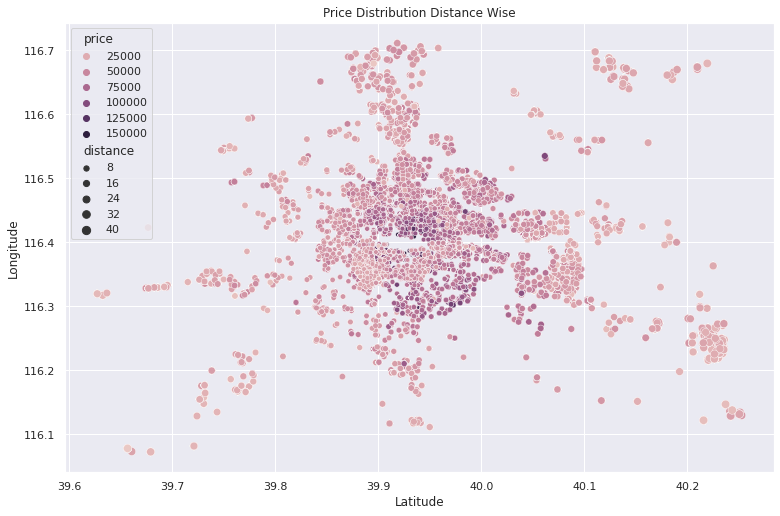

In [7]:
# Distance Impact on the Price

sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.scatterplot(data=df, x="Lat", y="Lng", hue="price",size = 'distance',
                     legend='brief')
ax.set(xlabel="Latitude", ylabel = "Longitude",title = "Price Distribution Distance Wise")

[Text(0.5, 0, 'Latitude'),
 Text(0, 0.5, 'Longitude'),
 Text(0.5, 1.0, 'Price Distribution District Wise')]

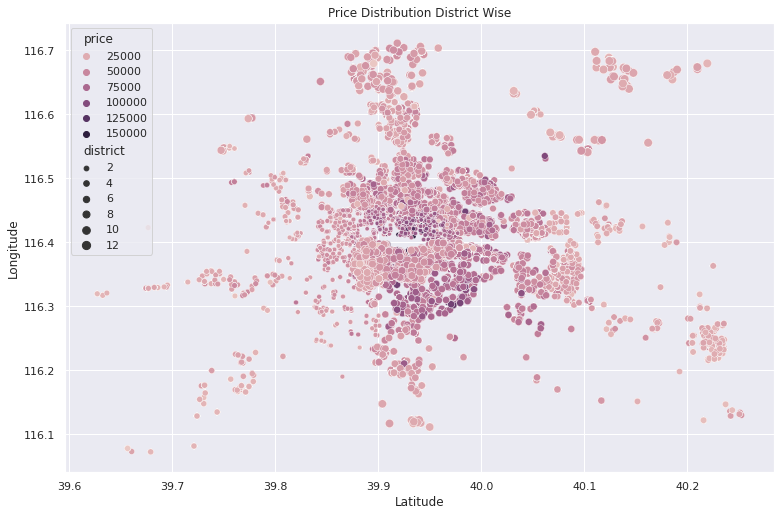

In [8]:
# District wise Price

sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.scatterplot(data=df, x="Lat", y="Lng", hue="price",size = 'district',
                     legend='brief')
ax.set(xlabel="Latitude", ylabel = "Longitude",title = "Price Distribution District Wise")

[Text(0.5, 0, 'Latitude'),
 Text(0, 0.5, 'Longitude'),
 Text(0.5, 1.0, 'Age Distributio District Wise')]

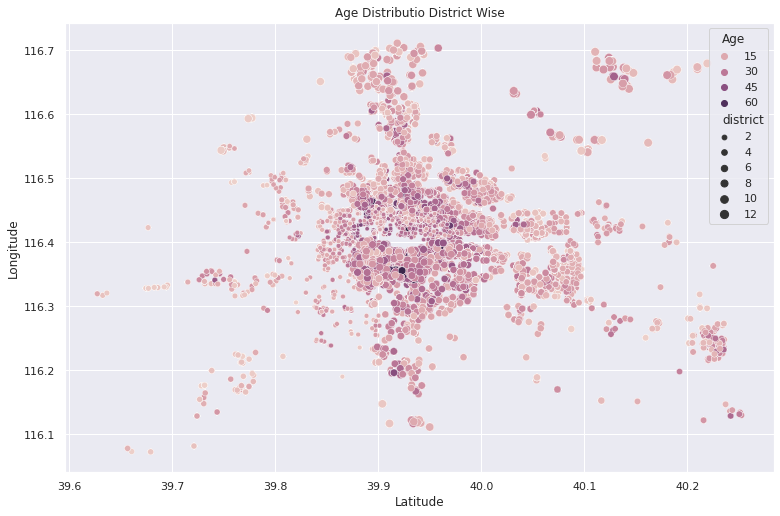

In [9]:
# Age wise Distribution

sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.scatterplot(data=df, x="Lat", y="Lng", hue="Age",size = 'district',
                     legend='brief')
ax.set(xlabel="Latitude", ylabel = "Longitude",title = "Age Distributio District Wise")

[Text(0.5, 0, 'Districts'),
 Text(0, 0.5, 'Price'),
 Text(0.5, 1.0, 'Correlation between District and Price')]

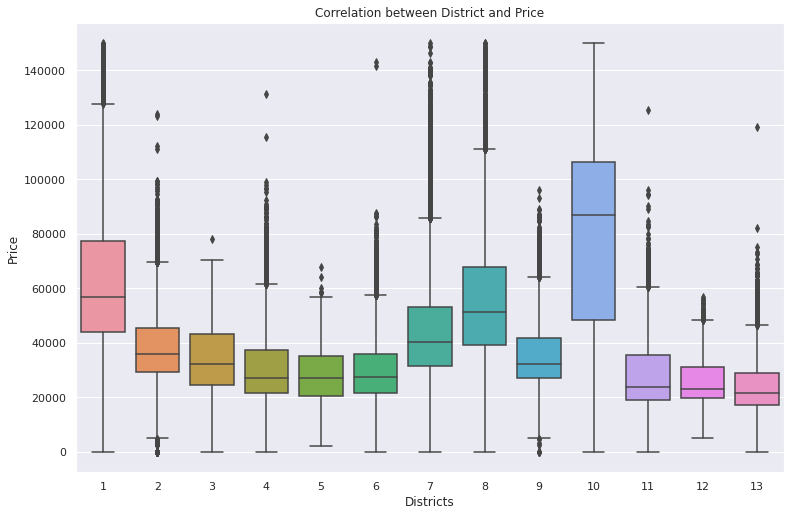

In [10]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.boxplot(data=df, x="district", y="price")
ax.set(xlabel="Districts", ylabel = "Price",title = "Correlation between District and Price")

[Text(0.5, 0, 'Building Type'),
 Text(0, 0.5, 'Price'),
 Text(0.5, 1.0, 'Correlation between Building Type and Price')]

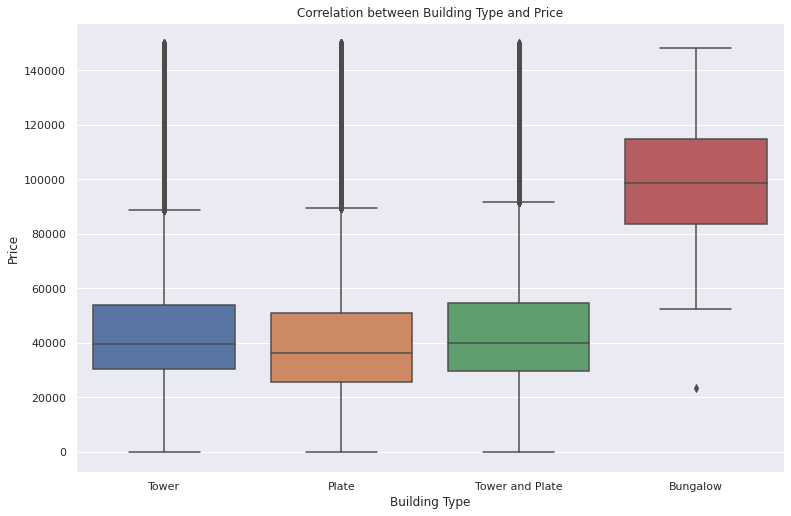

In [11]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.boxplot(data=df, x="buildingType", y="price")
ax.set(xlabel="Building Type", ylabel = "Price",title = "Correlation between Building Type and Price")

[Text(0.5, 0, 'Building Type'),
 Text(0, 0.5, 'Square'),
 Text(0.5, 1.0, 'Correlation between Building Type and Square')]

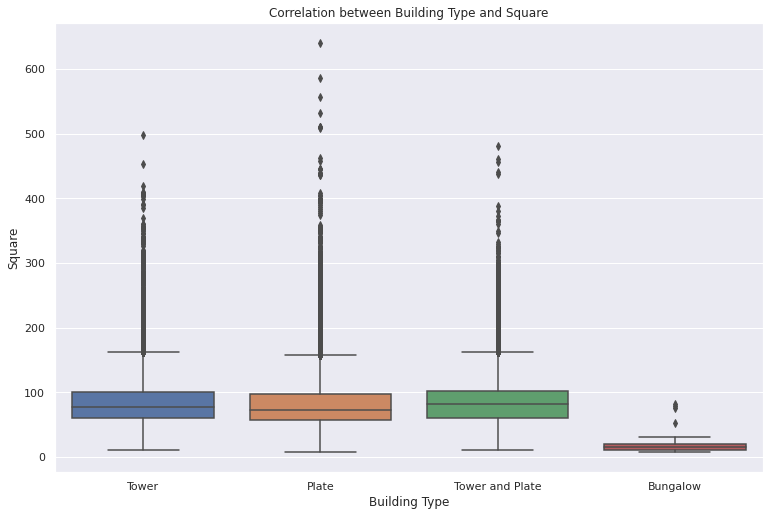

In [12]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.boxplot(data=df, x="buildingType", y="square")
ax.set(xlabel="Building Type", ylabel = "Square",title = "Correlation between Building Type and Square")

### After creating visualizations, the impact on the prices is visible.

### In figures "Price Distribution Distance and District wise", the most expensive houses centralizes close to the center of Beijing, while the cheapest ones spread in the suburban periphery

### In figure "Age Distribution District Wise", the oldest houses are concentrated densely in the center of Beijing, while the newest ones are spread sparsely in the suburban areas.

### Since the patterns in these figures are similar, a strong correlation between location, age, and price can be observed. 

### There are also noticeable differences in housing prices across 13 districts, which are summarized in Fig. "Correlation between District and Price" with outliers are clearly visible

### Besides the location features, other features of the house also significantly contribute to the models’ performance. In the Correlation between BuildingType and Price figure, the difference in price among several building types can be clearly illustrated. Since bungalow is an old building type and is more likely to be built close to the center of Beijing, its price is costly regardless of the small area of a house ( correlation between BuildingType and Square figure)

### After feature engineering, now the dataset is checked for outliers. 

### There are 10 categorical features, and 9 are numerical ones.

### We have to visualize each numerical feature through "Box Plot" graph to see outliers first. Then apply the equation (1) to exclude them 

### Through Inter-Quartile Range (IQR), an outlier x can be detected if:
###          x < Q1 − 1.5 · IQR OR Q3 + 1.5 · IQR < x        (1)
### where:
###       Q1 = 25th percentiles Q3 = 75th percentiles IQR = Q3 − Q1

### To find percentile values, we will find the stats summary through pandas function, applied on each feature.

### Then we will apply equation (1) to every numerical feature of the dataset except the target feature.



### 1. "Lng" Longitude of the House

<AxesSubplot:>

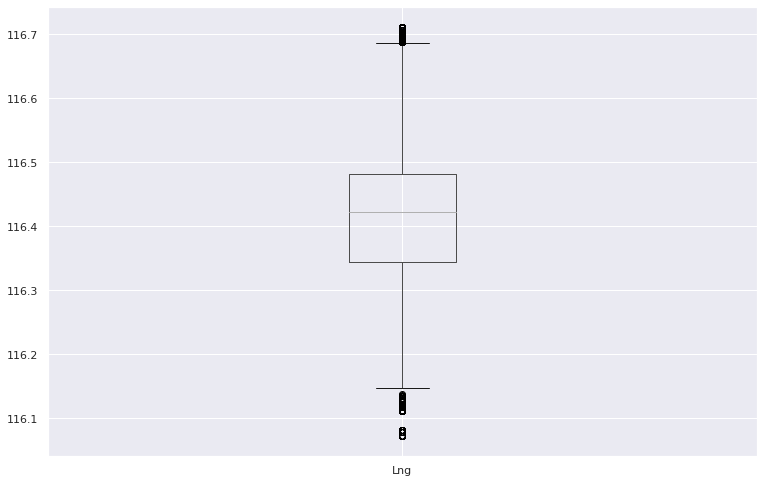

In [13]:
df.boxplot(['Lng'])

In [14]:
df['Lng'].describe()

count    277442.000000
mean        116.421548
std           0.113887
min         116.072514
25%         116.344557
50%         116.422099
75%         116.481385
max         116.711337
Name: Lng, dtype: float64

In [15]:
# For 'Lng' Outliers
outliers_Lng = []
Q1 = 116.344557
Q3 = 116.481385
IQR = Q3 - Q1
for x in df['Lng'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_Lng:
            outliers_Lng.append(x)

#print (sorted(outliers_Lng))
for outlier in outliers_Lng:
    df = df[df['Lng']!=outlier]
print ("DATA", df.shape)

DATA (271244, 20)


### 2. "Lat" Latitude of the House

<AxesSubplot:>

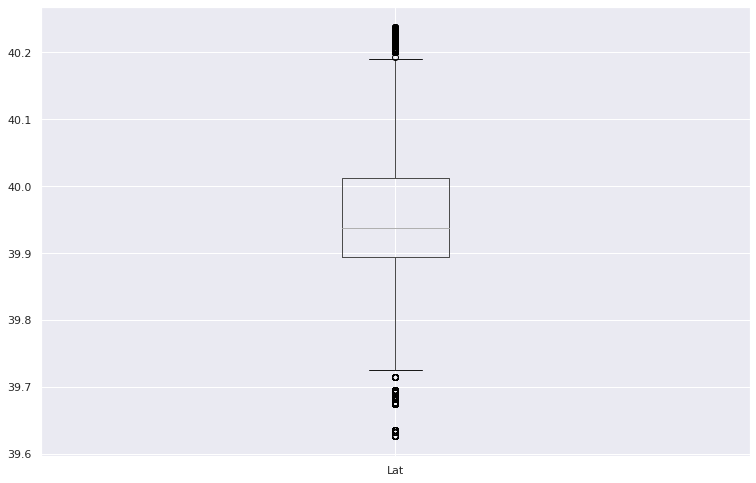

In [16]:
df.boxplot('Lat')

In [17]:
df['Lat'].describe()

count    271244.000000
mean         39.953164
std           0.093575
min          39.627030
25%          39.894045
50%          39.937341
75%          40.012518
max          40.237299
Name: Lat, dtype: float64

In [18]:
# For 'Lat' Outliers
outliers_Lat = []
Q1 = 39.894045
Q3 = 40.012518
IQR = Q3 - Q1
for x in df['Lat'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_Lat:
            outliers_Lat.append(x)

#print (sorted(outliers_Lat))
for outlier in outliers_Lat:
    df = df[df['Lat']!=outlier]
print ('DATA', df.shape)

DATA (267958, 20)


### 3. "distance" Distance to the Center of Beijing

<AxesSubplot:>

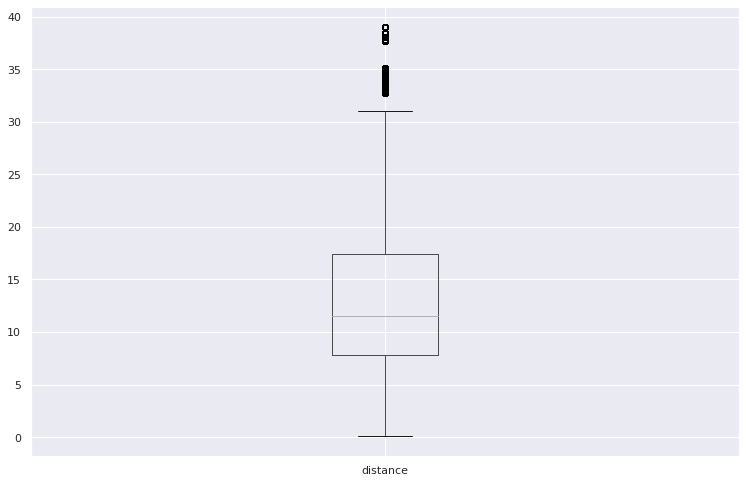

In [19]:
df.boxplot(['distance'])

In [20]:
df['distance'].describe()

count    267958.000000
mean         12.811291
std           6.438353
min           0.123822
25%           7.821041
50%          11.559560
75%          17.444622
max          38.987065
Name: distance, dtype: float64

In [21]:
# For 'distance' Outliers
outliers_dist = []
Q1 =  7.821041
Q3 = 17.444622
IQR = Q3 - Q1
for x in df['distance'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_dist:
            outliers_dist.append(x)

#print (sorted(outliers_dist))
for outlier in outliers_dist:
    df = df[df['distance']!=outlier]
print ('DATA' ,df.shape)

DATA (262818, 20)


### 4. "Age" Age of the House

<AxesSubplot:>

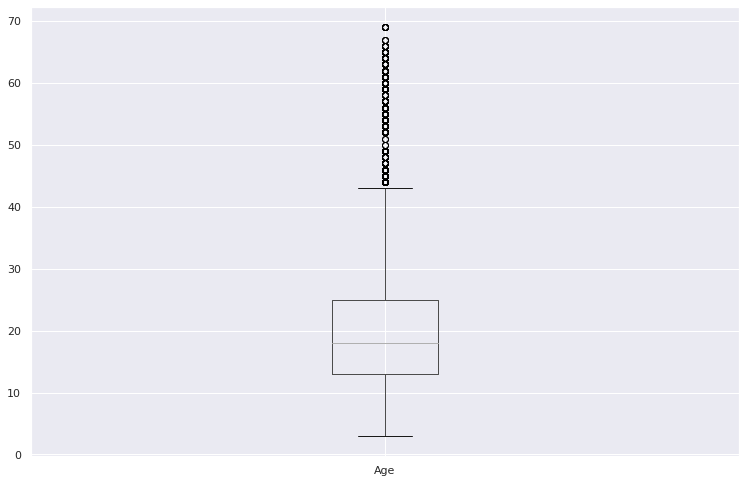

In [22]:
df.boxplot('Age')

In [23]:
df['Age'].describe()

count    262818.000000
mean         19.634275
std           8.535563
min           3.000000
25%          13.000000
50%          18.000000
75%          25.000000
max          69.000000
Name: Age, dtype: float64

In [24]:
# For 'Age' Outliers
outliers_age = []
Q1 = 13
Q3 = 25
IQR = Q3 - Q1
for x in df['Age'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_age:
            outliers_age.append(x)

#print (sorted(outliers_age))
for outlier in outliers_age:
    df = df[df['Age']!=outlier]
print ("DATA" ,df.shape)

DATA (261177, 20)


### 5. "square" Area of the House

<AxesSubplot:>

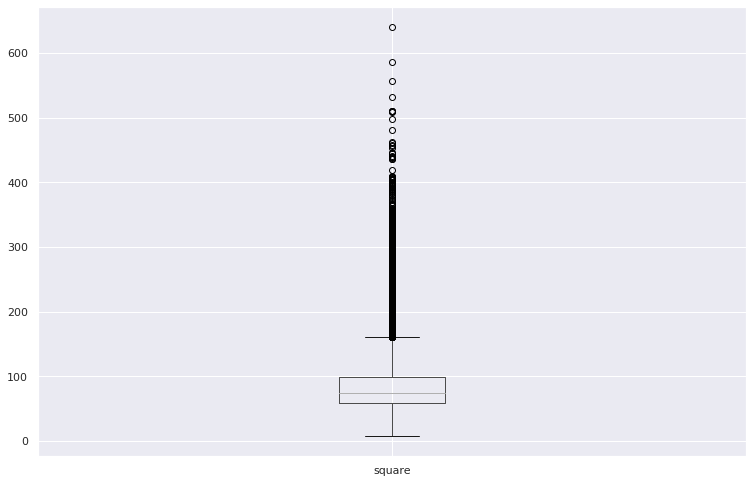

In [25]:
df.boxplot('square')

In [26]:
df['square'].describe()

count    261177.000000
mean         83.599739
std          36.174081
min           7.800000
25%          58.280000
50%          74.800000
75%          99.330000
max         640.000000
Name: square, dtype: float64

In [27]:
# For 'square' Outliers
outliers_square = []
Q1 = 58.280000
Q3 = 99.330000
IQR = Q3 - Q1
for x in df['square'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_square:
            outliers_square.append(x)

#print (sorted(outliers_square))
for outlier in outliers_square:
    df = df[df['square']!=outlier]
print ('DATA', df.shape)

DATA (251869, 20)


### 6. "Community Average" Average Housing Price of the Community

<AxesSubplot:>

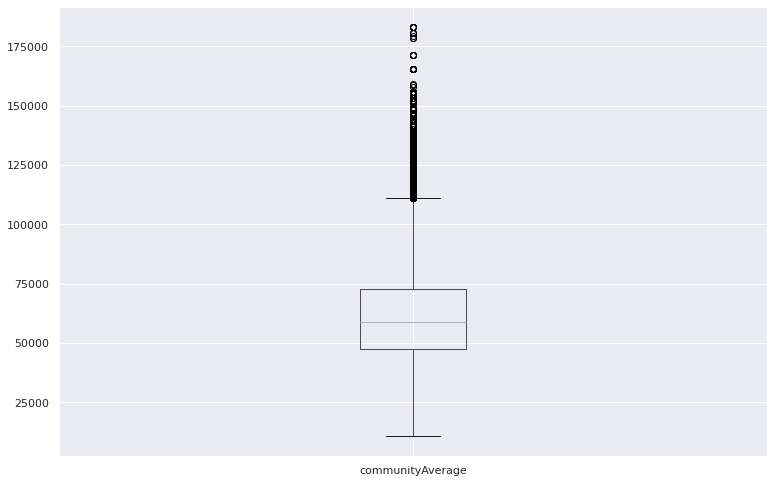

In [28]:
df.boxplot('communityAverage')

In [29]:
df['communityAverage'].describe()

count    251869.000000
mean      62283.812319
std       19592.438633
min       10847.000000
25%       47402.000000
50%       58959.000000
75%       72877.000000
max      183109.000000
Name: communityAverage, dtype: float64

In [30]:
# For 'communityAverage' Outliers
outliers_cA = []
Q1 = 47402.000000
Q3 = 72877.000000
IQR = Q3 - Q1
for x in df['communityAverage'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_cA:
            outliers_cA.append(x)

#print (sorted(outliers_cA))
for outlier in outliers_cA:
    df = df[df['communityAverage']!=outlier]
print ('DATA', df.shape)

DATA (246295, 20)


### 7. "followers" Number of Followers

<AxesSubplot:>

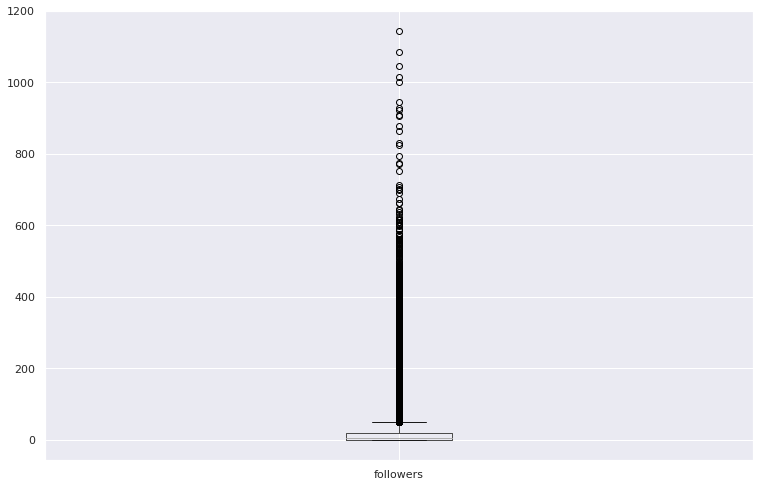

In [31]:
df.boxplot(['followers'])

In [32]:
df['followers'].describe()

count    246295.000000
mean         18.010016
std          36.101877
min           0.000000
25%           0.000000
50%           5.000000
75%          20.000000
max        1143.000000
Name: followers, dtype: float64

In [33]:
# For 'followers' Outliers
outliers_followers = []
Q1 = 0
Q3 = 20
IQR = Q3 - Q1
for x in df['followers'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_followers:
            outliers_followers.append(x)

#print (sorted(outliers_followers))
for outlier in  outliers_followers:
    df = df[df['followers']!=outlier]
print ('DATA', df.shape)

DATA (222898, 20)


### 8. "tradeTime" Trade Time (2002-2018)

<AxesSubplot:>

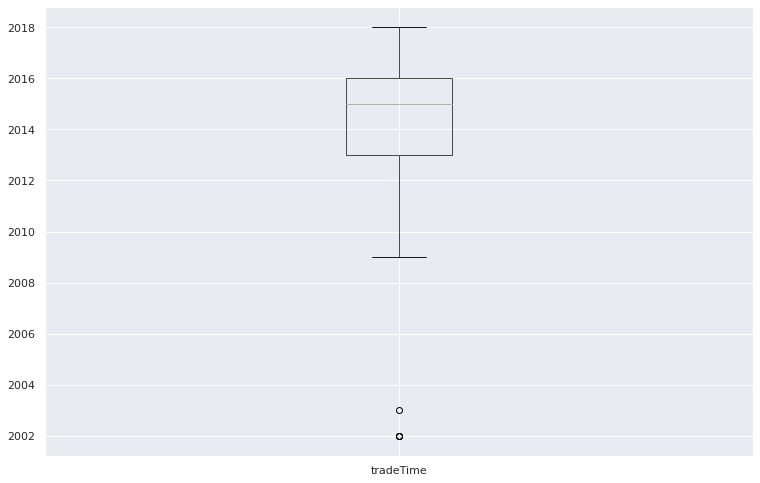

In [34]:
df.boxplot(['tradeTime'])

In [35]:
df['tradeTime'].describe()

count    222898.000000
mean       2014.644712
std           1.662109
min        2002.000000
25%        2013.000000
50%        2015.000000
75%        2016.000000
max        2018.000000
Name: tradeTime, dtype: float64

In [36]:
# For 'followers' Outliers
outliers_tradeTime = []
Q1 = 2013
Q3 = 2016
IQR = Q3 - Q1
for x in df['tradeTime'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_tradeTime:
            outliers_tradeTime.append(x)

#print (sorted(outliers_tradeTime))
df = df[df['tradeTime'] != 2002]
print ('DATA',df.shape)

DATA (222895, 20)


### 9. ladderRatio" Ratio b/w population and # of elevators of floor

<AxesSubplot:>

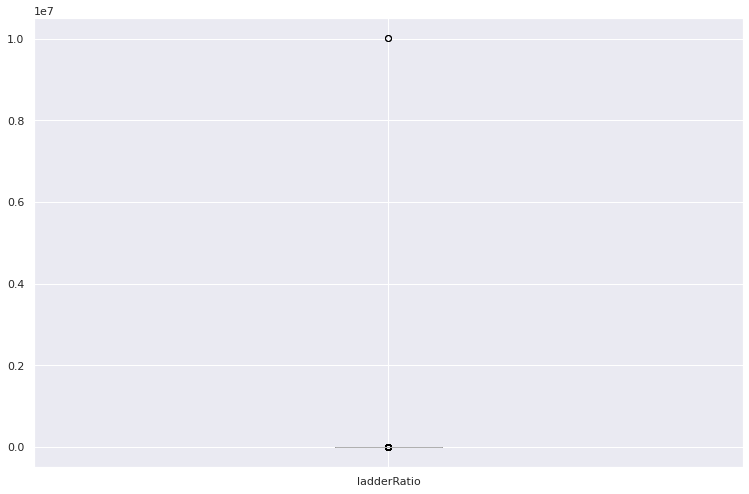

In [37]:
df.boxplot(['ladderRatio'])

In [38]:
df['ladderRatio'].describe()

count    2.228950e+05
mean     9.018950e+01
std      2.998278e+04
min      1.400000e-02
25%      2.500000e-01
50%      3.330000e-01
75%      5.000000e-01
max      1.000940e+07
Name: ladderRatio, dtype: float64

In [39]:
# For 'ladderRatio' Outliers
outliers_ladderRatio = []
Q1 = 2.500000e-01
Q3 = 5.000000e-01
IQR = Q3 - Q1
for x in df['ladderRatio'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_ladderRatio:
            outliers_ladderRatio.append(x)

#print (sorted(outliers_ladderRatio))
for outlier in outliers_ladderRatio:
    df = df[df['ladderRatio']!=outlier]
print ('DATA', df.shape)

DATA (219271, 20)


### As we know that there are 10 categorical features in the dataset. These should be converted to numerical finite values. Machine Learning algorithms only deal with numerical values. Giving finite values to these features will act in the same manner as a categorical feature. There will be no difference. The categorical features are

### 1. "livingRoom" Number of bedrooms
### 2. "subway" Whether the house is near any subways
### 3. "fiveYearsProperty" Whether the house is a five-year property
### 4. "elevator" Whether the house has any elevator
### 5. "floorHeight" The Floor Height"
### 6. "buildingStructure" Building Structure
### 7. "renovationCondition" Renovation Condition
### 8. "buildingType" Building Type
### 9. "floorType" Floor height relative to the building
### 10. "district" District (District 1- District 13)

### Some are already in numeric form while others have to be transformed.

In [40]:
# Label Encoding of Categorical Features
lbl = LabelEncoder()
# 'floorType'
lbl.fit(list(df['floorType'].values) + list(df['floorType'].values))
df['floorType'] = lbl.transform(list(df['floorType'].values))
# 'buildingType'
lbl.fit(list(df['buildingType'].values) + list(df['buildingType'].values))
df['buildingType'] = lbl.transform(list(df['buildingType'].values))

### Now all are converted. Lets check data type of each feature for algorithm and the remaining data (219271) after excluding all the outliers

In [41]:
print ( "The DATA" , df.shape)
df.dtypes

The DATA (219271, 20)


Lng                    float64
Lat                    float64
tradeTime                int64
followers                int64
price                  float64
square                 float64
livingRoom               int64
buildingType             int64
renovationCondition      int64
buildingStructure        int64
ladderRatio            float64
elevator                 int64
fiveYearsProperty        int64
subway                   int64
district                 int64
communityAverage       float64
distance               float64
Age                      int64
floorType                int64
floorHeight              int64
dtype: object

### The Final Data

### According to the paper, their data after omitting outliers contained 231962 data of rows with 19 features. Though we collected 219271 data of rows after performing all the operations. The error is 5% which is acceptable due to any reason like the different approach of the researcher towards data handling in some parts of the data which we considered differently.   

### Features Selection

### Selecting features is always based on statistical information. That's why we have to check the correlation as well as the p-value between the target feature "price" and all the other features.

### The statistical Analysis provides the statistical significance of any feature (the independent variables) for the target or dependent variable. 

### In statistics, "the p-value is the probability of obtaining results at least as extreme as the observed results of a statistical hypothesis test, assuming that the null hypothesis is correct. A smaller p-value means that there is stronger evidence in favor of the alternative hypothesis".


### P-Value is the threshold to check the significance. If P-value < 0.01 or 0.05 or 0.1 (99% or 95% or 90% Significance Levels ) of any independent variable, it is become statistically significant to affect the outcome. In our case, any statistically significant variable will affect the Housing Price. 

### There are mathematical (Stats library SciPy) and visualization (Heat Map) ways to determine the p-value and the correlation like strong, modest, or weak relation either positive or negative relationship with the predicted variables.

<AxesSubplot:>

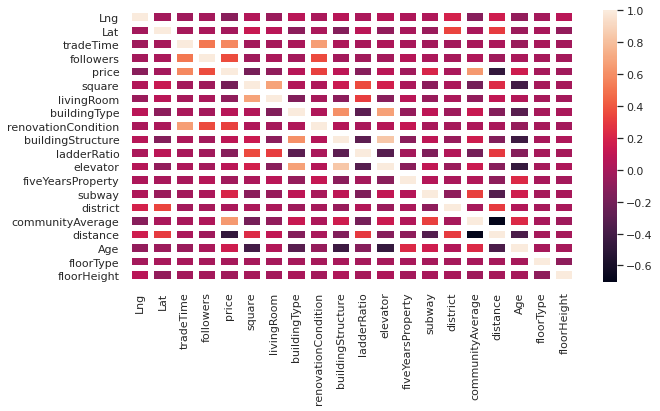

In [42]:
### View of Correlation Matrix Through head map
corr_matrix=df._get_numeric_data().corr()
fig, ax = plt.subplots(figsize=(10,5))         # Sample figsize in inches
sns.heatmap(corr_matrix, annot=False, linewidths=5, ax=ax, xticklabels=corr_matrix.columns.values,yticklabels=corr_matrix.columns.values)
#sns.heatmap(corr, annot=True, fmt=".1f",linewidth=0.5 xticklabels=corr.columns.values,yticklabels=corr.columns.values)

In [43]:
# finding correlation and p_value
pearson_coef, p_value = stats.pearsonr(df['Lng'], df['price'])
print(" The Pearson Correlation Coefficient 'Lng' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['Lat'], df['price'])
print(" The Pearson Correlation Coefficient 'Lat' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['tradeTime'], df['price'])
print(" The Pearson Correlation Coefficient 'tradeTime' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['followers'], df['price'])
print(" The Pearson Correlation Coefficient 'followers' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['square'], df['price'])
print(" The Pearson Correlation Coefficient 'square' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['livingRoom'], df['price'])
print(" The Pearson Correlation Coefficient 'livingRoom' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['buildingType'], df['price'])
print(" The Pearson Correlation Coefficient 'buildingType' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['renovationCondition'], df['price'])
print(" The Pearson Correlation Coefficient 'renovationCondition' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['buildingStructure'], df['price'])
print(" The Pearson Correlation Coefficient 'buildingStructure' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['ladderRatio'], df['price'])
print(" The Pearson Correlation Coefficient 'ladderRatio' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['elevator'], df['price'])
print(" The Pearson Correlation Coefficient 'elevator' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['fiveYearsProperty'], df['price'])
print(" The Pearson Correlation Coefficient 'fiveYearsProperty' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['communityAverage'], df['price'])
print(" The Pearson Correlation Coefficient 'communityAverage' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df[ 'distance'], df['price'])
print(" The Pearson Correlation Coefficient  'distance' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['Age'], df['price'])
print(" The Pearson Correlation Coefficient 'Age' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['subway'], df['price'])
print(" The Pearson Correlation Coefficient 'subway' is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['district'], df['price'])
print(" The Pearson Correlation Coefficient 'district'is", pearson_coef, " with a P-value of P =", p_value)
pearson_coef, p_value = stats.pearsonr(df['floorHeight'], df['price'])
print(" The Pearson Correlation Coefficient 'floorHeight' is", pearson_coef, " with a P-value of P =", p_value)


 The Pearson Correlation Coefficient 'Lng' is -0.1117299402522594  with a P-value of P = 0.0
 The Pearson Correlation Coefficient 'Lat' is -0.005141364855193738  with a P-value of P = 0.01606140102176021
 The Pearson Correlation Coefficient 'tradeTime' is 0.5793904031827056  with a P-value of P = 0.0
 The Pearson Correlation Coefficient 'followers' is 0.36293671696533136  with a P-value of P = 0.0
 The Pearson Correlation Coefficient 'square' is -0.18656499623977163  with a P-value of P = 0.0
 The Pearson Correlation Coefficient 'livingRoom' is -0.08633693692340277  with a P-value of P = 0.0
 The Pearson Correlation Coefficient 'buildingType' is 0.06764167583965638  with a P-value of P = 1.1208469643905762e-220
 The Pearson Correlation Coefficient 'renovationCondition' is 0.3215348200580513  with a P-value of P = 0.0
 The Pearson Correlation Coefficient 'buildingStructure' is 0.09094124289072963  with a P-value of P = 0.0
 The Pearson Correlation Coefficient 'ladderRatio' is -0.1217252

### Through visualization and statistical findings; most features have a very small p-value which indicates the null hypothesis is true. Or in other words, they are highly significant.

### Though the correlation is weak for most of the features, but due to dealing with a large sample and keep in mind the p-values, they can be statistically significant.

### Therefore we will pick all the 19 independent features in the dataset to predict the housing prices as did by the researcher.

## 2.3 Model Selection & Evaluation

### The algorithms are dealing with two types of methods, Regression and Classification. As we are predicting prices, it means we will go for regression models.  We will select five different algorithms such as "Random Forest", "Extreme Gradient Boosting (XGBoost)", "Light Gradient Boosting Machine (LightGBM)", "Hybrid Regression" and "Stacked Generalization". The purpose of selecting more than one algorithm is to verify the accuracy across each model to ensure good predicting results.

### After predicting results, the evaluation is a must to put a stamp on your work. We will use the "Root Mean Squared Logarithmic Error (RMSLE)" evaluation technique to check the results. 

### RMSLE is robust to outliers. It only considers the relative error between the Predicted and the actual value, and the scale of the error is not significant. RMSLE incurs a larger penalty for the underestimation of the Actual variable than the Overestimation. In simple words, more penalty is incurred when the predicted value is less than the Actual Value. On the other hand, a Less penalty is incurred when the predicted value is more than the actual value.

## 2.3.1 Random Forest Classifier

### A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree. 

### The advantages of random forest are

### 1. Decorrelate trees
### 2. Error reducer
### 3. Good performer on imbalanced dataset
### 4. Good in Handling the huge amount of data
### 5. Little impact of outliers
### 6. Robust to overfitting

### Similarly the disadvantages are

### 1. Features need to have some predictive power else they won’t work.
### 2. Predictions of the trees need to be uncorrelated.
### 3. Appears as Black Box: It is tough to know what is happening. You can at best try different parameters and random seeds to change the outcomes and performance.

In [44]:
# All the columns
df.columns

Index(['Lng', 'Lat', 'tradeTime', 'followers', 'price', 'square', 'livingRoom',
       'buildingType', 'renovationCondition', 'buildingStructure',
       'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district',
       'communityAverage', 'distance', 'Age', 'floorType', 'floorHeight'],
      dtype='object')

In [45]:
# Designing the Base For Each algorithm

# Feature Selection

X = df[['Lng', 'Lat', 'tradeTime', 'followers', 'square', 'livingRoom',
       'buildingType', 'renovationCondition', 'buildingStructure',
       'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district',
       'communityAverage', 'distance', 'Age', 'floorType', 'floorHeight']]

# Standardized the Features
X = np.asarray(X)
X = preprocessing.StandardScaler().fit(X).transform(X)  

# Selecting Target Feature
y =  np.asarray(df['price'])#.reshape(-1, 1)

# Split the data into training and test data to see results on the test data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Further spliting the Traning set into sub Train and Test Data to see results on training data
train_X,test_X,train_y,test_y = train_test_split(X_train,y_train,random_state=42)


In [46]:
%%time
# Model Trainng For Training Set
# Specify Model
rf = RandomForestRegressor(random_state=42,n_estimators=900,max_depth=20,
                                              n_jobs=-1,min_samples_split=10,) #110,325
# Fit Model

rf.fit(train_X, train_y.ravel())

# Make validation predictions

pred_y = rf.predict(test_X)

# Model Evaluation

print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( pred_y, test_y))))
#print ("Model Accuracy {:,.5f}".format(rf.score(X_test, y_test)))

RMSLE 0.29238
CPU times: user 17min 15s, sys: 2.32 s, total: 17min 18s
Wall time: 4min 25s


### The error is low (0.292), it means the algorithm is not working badly. We can ensure the results through visualization too.

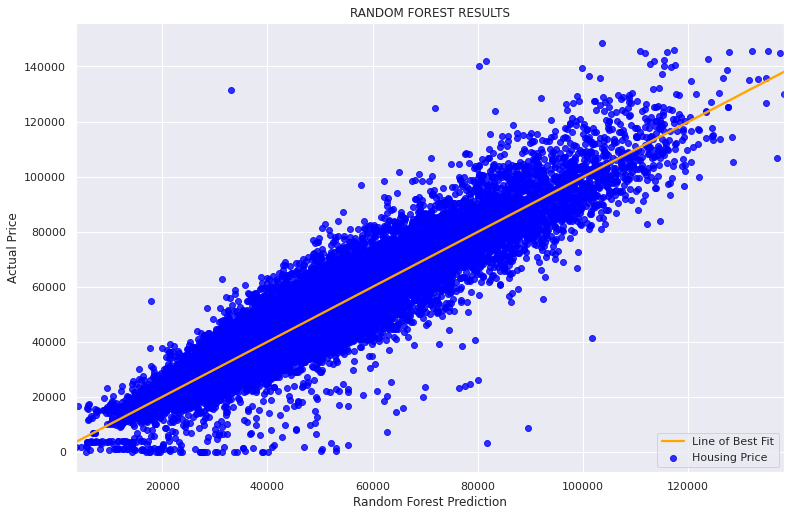

In [47]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(pred_y,test_y,color = 'blue',line_kws={'color':'orange'})#,hue='y_test')

ax.set(xlabel="Random Forest Prediction", ylabel = "Actual Price",title = "RANDOM FOREST RESULTS")
ax.legend(['Line of Best Fit', 'Housing Price'], loc='lower right')

### It is clear from the above figure that both prices are directly proportional. So the predicted results are good for the training data.

In [48]:
%%time
# Model Trainng For Test Data
# Specify Model
rf = RandomForestRegressor(random_state=42,n_estimators=900,max_depth=20,
                                              n_jobs=-1,min_samples_split=10,) #110,325
# Fit Model

rf.fit(X_train, y_train.ravel())

# Make validation predictions

y_pred = rf.predict(X_test)

# Model Evaluation

print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( y_pred, y_test))))
#print ("Model Accuracy {:,.5f}".format(rf.score(X_test, y_test)))

RMSLE 0.30224
CPU times: user 23min 11s, sys: 2.4 s, total: 23min 14s
Wall time: 5min 55s


### The error on the test data is also low (0.302), it means the algorithm is not working badly. We can ensure the results through visualization 

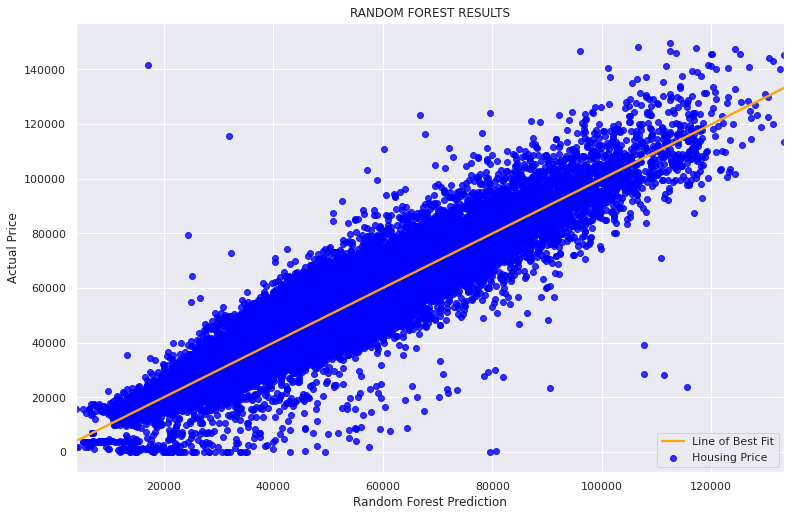

In [49]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(y_pred,y_test,color = 'blue',line_kws={'color':'orange'})#,hue='y_test')

ax.set(xlabel="Random Forest Prediction", ylabel = "Actual Price",title = "RANDOM FOREST RESULTS")
ax.legend(['Line of Best Fit', 'Housing Price'], loc='lower right')

### It is clear from the above figure that both prices are directly proportional. So the predicted results are good for the test data.

## 2.3.2 Light Gradient Boosting Machine (LightGBM)

### LightGBM uses a novel technique of Gradient-based One-Side Sampling (GOSS) to filter out the data instances for finding a split value

### Advantages of Light GBM

### Faster training speed and higher efficiency: Light GBM use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure.

### Lower memory usage: Replaces continuous values to discrete bins which result in lower memory usage.

### Better accuracy than any other boosting algorithm: It produces much more complex trees by following leaf wise split approach rather than a level-wise approach which is the main factor in achieving higher accuracy. However, it can sometimes lead to overfitting which can be avoided by setting the max_depth parameter.

### Compatibility with Large Datasets: It is capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBOOST.

### Disadvantages of Light GBM

### Boosting models are more prone to over-fitting , bagging models on other hand is simple to use and doesn't have lot of hyper parameter.


In [50]:
%%time
# Light GBM Model Training For Training Data

import lightgbm as lgb
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=36,learning_rate=0.15,
                        n_estimators=64,min_child_weight = 2, colsample_bytree = 0.8,
                        reg_lambda = 0.45)
gbm.fit(train_X, train_y,
    eval_set=[(test_X, test_y)],
    eval_metric='l2_root',
    early_stopping_rounds=50)
pred_y = gbm.predict(test_X, num_iteration=gbm.best_iteration_)
#accuracy = round(gbm.score(X_train, y_train)*100,2)
#mse = mean_squared_error(y_test,y_pred)
#rmse = np.sqrt(mse)
print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( pred_y, test_y))))

[1]	valid_0's rmse: 17613	valid_0's l2: 3.10218e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 16260.8	valid_0's l2: 2.64412e+08
[3]	valid_0's rmse: 14321.5	valid_0's l2: 2.05104e+08
[4]	valid_0's rmse: 12735.7	valid_0's l2: 1.62198e+08
[5]	valid_0's rmse: 12011.1	valid_0's l2: 1.44266e+08
[6]	valid_0's rmse: 11448.3	valid_0's l2: 1.31064e+08
[7]	valid_0's rmse: 10418.7	valid_0's l2: 1.08549e+08
[8]	valid_0's rmse: 9598.13	valid_0's l2: 9.21241e+07
[9]	valid_0's rmse: 8955.39	valid_0's l2: 8.0199e+07
[10]	valid_0's rmse: 8450.66	valid_0's l2: 7.14136e+07
[11]	valid_0's rmse: 8057.7	valid_0's l2: 6.49266e+07
[12]	valid_0's rmse: 7763.46	valid_0's l2: 6.02714e+07
[13]	valid_0's rmse: 7644.5	valid_0's l2: 5.84384e+07
[14]	valid_0's rmse: 7419.67	valid_0's l2: 5.50515e+07
[15]	valid_0's rmse: 7244.77	valid_0's l2: 5.24867e+07
[16]	valid_0's rmse: 7181.83	valid_0's l2: 5.15786e+07
[17]	valid_0's rmse: 7057.88	valid_0's l2: 4.98136e+07
[18]	valid_0's rms

### The error is low (0.297), it means the algorithm is not working badly. We can ensure the results through visualization 

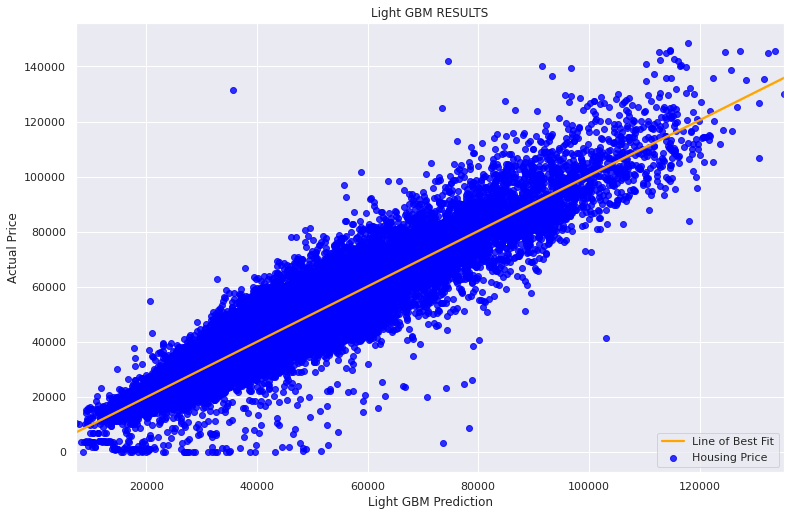

In [51]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(pred_y,test_y,color = 'blue',line_kws={'color':'orange'})#,hue='y_test')

ax.set(xlabel="Light GBM Prediction", ylabel = "Actual Price",title = "Light GBM RESULTS")
ax.legend(['Line of Best Fit', 'Housing Price'], loc='lower right')

### It is clear from the above figure that both prices are directly proportional. So the predicted results are good for the training data.

In [52]:
%%time
# Light GBM Model Training For Test Data

import lightgbm as lgb
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=36,learning_rate=0.15,
                        n_estimators=64,min_child_weight = 2, colsample_bytree = 0.8,
                        reg_lambda = 0.45)
gbm.fit(X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='l2_root',
    early_stopping_rounds=50)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
#accuracy = round(gbm.score(X_train, y_train)*100,2)
#mse = mean_squared_error(y_test,y_pred)
#rmse = np.sqrt(mse)
print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( y_pred, y_test))))

[1]	valid_0's rmse: 17377.4	valid_0's l2: 3.01975e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 16038.5	valid_0's l2: 2.57233e+08
[3]	valid_0's rmse: 14137.9	valid_0's l2: 1.99879e+08
[4]	valid_0's rmse: 12584	valid_0's l2: 1.58358e+08
[5]	valid_0's rmse: 11879.3	valid_0's l2: 1.41118e+08
[6]	valid_0's rmse: 11321	valid_0's l2: 1.28164e+08
[7]	valid_0's rmse: 10314.4	valid_0's l2: 1.06386e+08
[8]	valid_0's rmse: 9514.64	valid_0's l2: 9.05283e+07
[9]	valid_0's rmse: 8887.32	valid_0's l2: 7.89844e+07
[10]	valid_0's rmse: 8398.18	valid_0's l2: 7.05294e+07
[11]	valid_0's rmse: 8014.81	valid_0's l2: 6.42372e+07
[12]	valid_0's rmse: 7728.99	valid_0's l2: 5.97373e+07
[13]	valid_0's rmse: 7618.27	valid_0's l2: 5.80381e+07
[14]	valid_0's rmse: 7401.07	valid_0's l2: 5.47758e+07
[15]	valid_0's rmse: 7235.51	valid_0's l2: 5.23526e+07
[16]	valid_0's rmse: 7178	valid_0's l2: 5.15237e+07
[17]	valid_0's rmse: 7061.78	valid_0's l2: 4.98688e+07
[18]	valid_0's rmse:

### The error on the test data is also low (0.308), it means the algorithm is not working badly. We can ensure the results through visualization. 

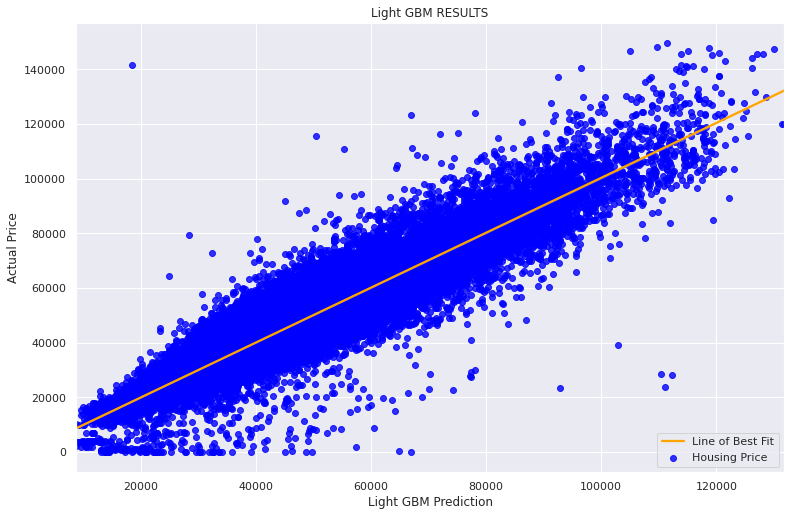

In [53]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(y_pred,y_test,color = 'blue',line_kws={'color':'orange'})#,hue='y_test')

ax.set(xlabel="Light GBM Prediction", ylabel = "Actual Price",title = "Light GBM RESULTS")
ax.legend(['Line of Best Fit', 'Housing Price'], loc='lower right')

### It is clear from the above figure that both prices are directly proportional. So the predicted results are good for the test data.

## 2.3.3 Extreme Gradient Boosting (XGBoost)

### XGBoost is a scalable machine learning system for tree boosting. The system is available as an open-source package.The system has generated a significant impact and been widely recognized in various machine learning and data mining challenges.

# PROS

### Less feature engineering required (No need for scaling, normalizing data, can also handle missing values well)

### Feature importance can be found out(it output importance of each feature, can be used for feature selection)

### Fast to interpret

### Outliers have minimal impact.

### Handles large sized datasets well.

### Good Execution speed

### Good model performance (wins most of the Kaggle competitions)

### Less prone to overfitting

# CONS

### Difficult interpretation , visualization tough
### Overfitting possible if parameters not tuned properly.
### Harder to tune as there are too many hyperparameters.

In [54]:
%%time
# XGBoost Model Training For Training Data
# Traing the Model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', min_child_weight = 2, subsample = 1,
                          colsample_bytree = 0.8,
                          learning_rate = 0.2, n_estimators = 500,
                         reg_lambda = 0.45, reg_alpha = 0, gamma = 0.5)

# Fitting the Model
xg_reg.fit(train_X,train_y)

# Predicting
pred_y = xg_reg.predict(test_X)

# Evaluation
print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( pred_y, test_y))))

RMSLE 0.29094
CPU times: user 1min 48s, sys: 104 ms, total: 1min 48s
Wall time: 27.4 s


### The error is low (0.291), it means the algorithm is not working badly. We can ensure the results through visualization 

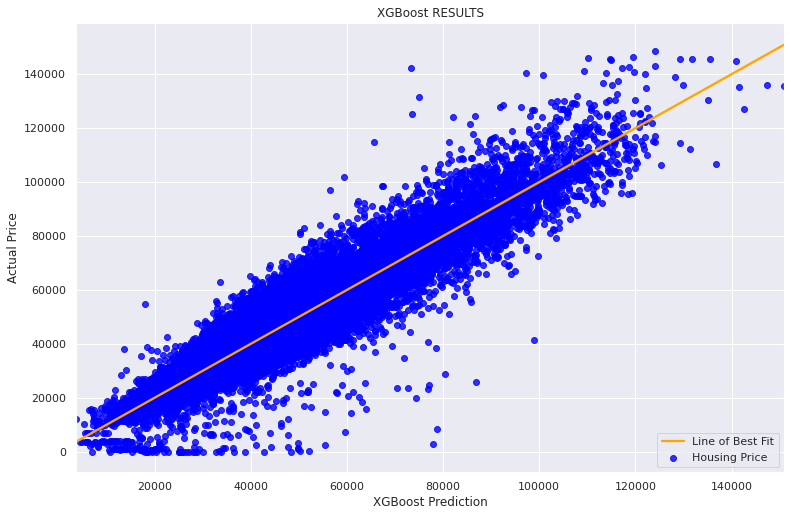

In [55]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(pred_y,test_y,color = 'blue',line_kws={'color':'orange'})#,hue='y_test')

ax.set(xlabel="XGBoost Prediction", ylabel = "Actual Price",title = "XGBoost RESULTS")
ax.legend(['Line of Best Fit', 'Housing Price'], loc='lower right')

### It is clear from the above figure that both prices are directly proportional. So the predicted results are good for the training data.

In [56]:
%%time
# XGBoost Model Training For Test Data
# Traing the Model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', min_child_weight = 2, subsample = 1,
                          colsample_bytree = 0.8,
                          learning_rate = 0.2, n_estimators = 500,
                         reg_lambda = 0.45, reg_alpha = 0, gamma = 0.5)

# Fitting the Model
xg_reg.fit(X_train,y_train)

# Predicting
y_pred = xg_reg.predict(X_test)

# Evaluation
print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( y_pred, y_test))))

RMSLE 0.30202
CPU times: user 2min 28s, sys: 210 ms, total: 2min 28s
Wall time: 37.9 s


### The error on the test data is very low (0.302), it means the algorithm is not working badly. We can ensure the results through visualization 

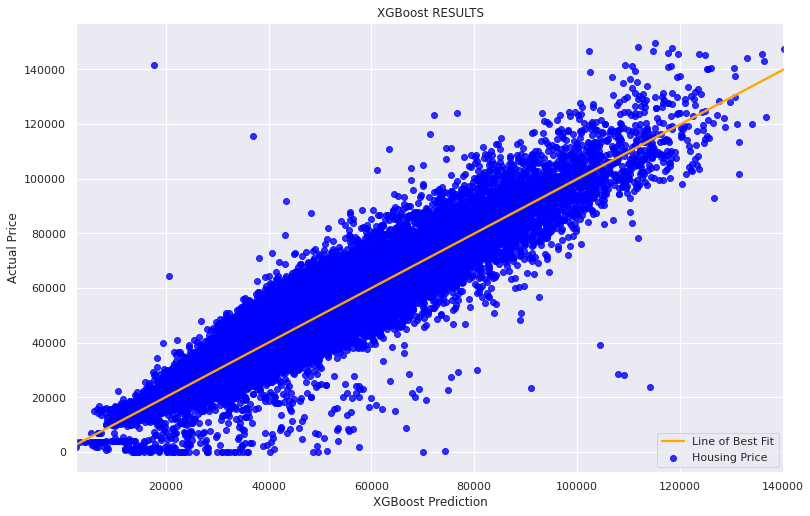

In [57]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(y_pred,y_test,color = 'blue',line_kws={'color':'orange'})#,hue='y_test')

ax.set(xlabel="XGBoost Prediction", ylabel = "Actual Price",title = "XGBoost RESULTS")
ax.legend(['Line of Best Fit', 'Housing Price'], loc='lower right')

### It is clear from the above figure that both prices are directly proportional. So the predicted results are good for the test data.

## 2.3.4 Hybrid Regression

### Hybrid Regression is a model that includes two or more different regression models. We will combine all the above three models to make a Hybrid model. 

### This method averages the individual predictions to form a final prediction. It is a fair approach to balance between bias and variance in the composite models. This technique also supports weight assignment to each component model, but it may lead to bias over one model, losing the benefits of generalization.

###  Hybrid Regression is actually a VotingRegressor algorithm in sklearn module. A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. Then it averages the individual predictions to form a final prediction.

In [58]:
%%time
# Hybrid MOdel Training For Training Data
# Model 1
r1 = xgb.XGBRegressor(objective ='reg:squarederror', min_child_weight = 2, subsample = 1,
                          colsample_bytree = 0.8,
                          learning_rate = 0.2, n_estimators = 500,
                         reg_lambda = 0.45, reg_alpha = 0, gamma = 0.5)
# Model 2
r2 = lgb.LGBMRegressor(objective='regression',num_leaves=36,learning_rate=0.15,
                        n_estimators=64,min_child_weight = 2, colsample_bytree = 0.8,
                        reg_lambda = 0.45)
# Model 3
r3 = RandomForestRegressor(random_state=42,n_estimators=900,max_depth=20,
                                              n_jobs=-1,min_samples_split=10,)

# Making Hybrid Model
vreg = VotingRegressor([('gb', r1), ('lgb', r2), ('rf', r3)])

# Fitting the Model
vreg.fit(train_X, train_y)

# Predicting the Model
pred_y = vreg.predict(test_X)

# Evaluation
print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( pred_y, test_y))))

RMSLE 0.29135
CPU times: user 2min 13s, sys: 2.29 s, total: 2min 15s
Wall time: 5min 22s


### The error is low (0.291), it means the algorithm is not working badly. We can ensure the results through visualization

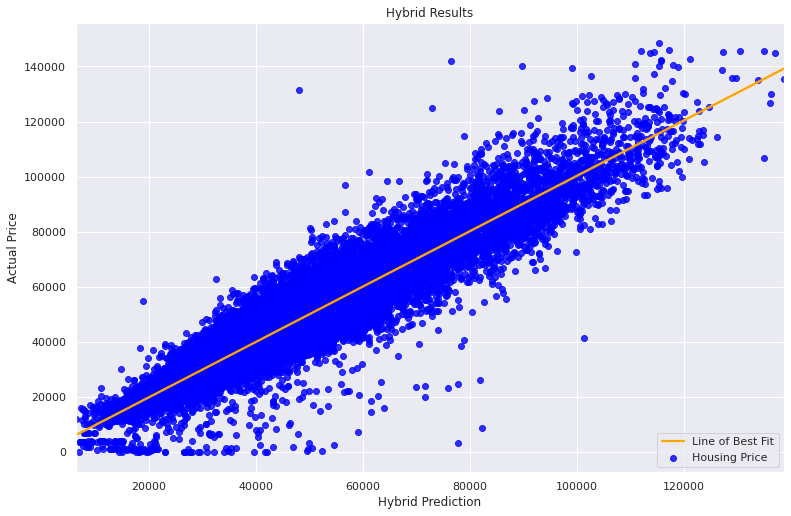

In [59]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(pred_y,test_y,color = 'blue',line_kws={'color':'orange'})#,hue='y_test')

ax.set(xlabel="Hybrid Prediction", ylabel = "Actual Price",title = "Hybrid Results")
ax.legend(['Line of Best Fit', 'Housing Price'], loc='lower right')

### It is clear from the above figure that both prices are directly proportional. So the predicted results are good for the training data.

In [60]:
%%time
# Hybrid Model Training For Test Data
# Model 1
r1 = xgb.XGBRegressor(objective ='reg:squarederror', min_child_weight = 2, subsample = 1,
                          colsample_bytree = 0.8,
                          learning_rate = 0.2, n_estimators = 500,
                         reg_lambda = 0.45, reg_alpha = 0, gamma = 0.5)
# Model 2
r2 = lgb.LGBMRegressor(objective='regression',num_leaves=36,learning_rate=0.15,
                        n_estimators=64,min_child_weight = 2, colsample_bytree = 0.8,
                        reg_lambda = 0.45)
# Model 3
r3 = RandomForestRegressor(random_state=42,n_estimators=900,max_depth=20,
                                              n_jobs=-1,min_samples_split=10,)

# Making Hybrid Model
vreg = VotingRegressor([('gb', r1), ('lgb', r2), ('rf', r3)])

# Fitting the Model
vreg.fit(X_train, y_train)

# Predicting the Model
y_pred = vreg.predict(X_test)

# Evaluation
print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( y_pred, y_test))))

RMSLE 0.30209
CPU times: user 3min, sys: 2.06 s, total: 3min 2s
Wall time: 7min 11s


The error is low (0.302), it means the algorithm is not working badly. We can ensure the results through visualization

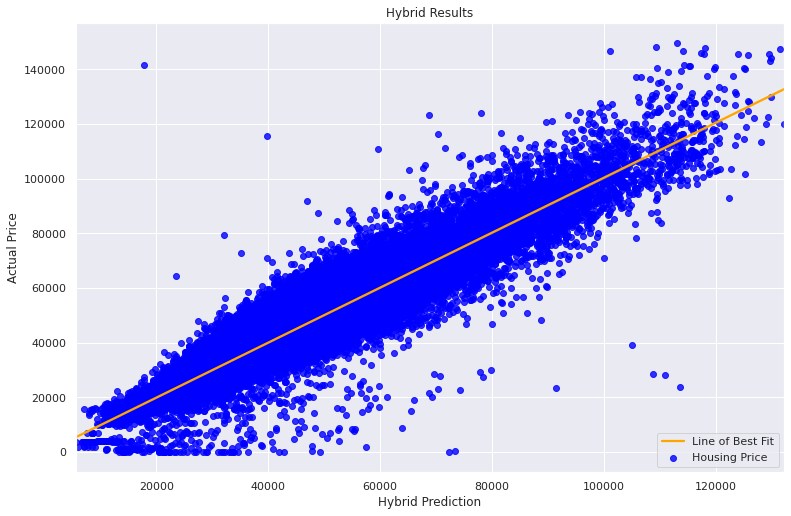

In [61]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(y_pred,y_test,color = 'blue',line_kws={'color':'orange'})#,hue='y_test')

ax.set(xlabel="Hybrid Prediction", ylabel = "Actual Price",title = "Hybrid Results")
ax.legend(['Line of Best Fit', 'Housing Price'], loc='lower right')

### It is clear from the above figure that both prices are directly proportional. So the predicted results are good for the test data.

## 2.3.5 Stacked Generalization

### Stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

### The main idea of this method is to use the predictions of previous models as features for another model. This approach also utilizes the k-fold cross-validation technique to avoid overfitting.

### sklearn module StackingRegressor is based on stacked generalization

In [62]:
%%time
# Stacked Model Training For Training Data

# Model 1
r1 = xgb.XGBRegressor(objective ='reg:squarederror', min_child_weight = 2, subsample = 1,
                          colsample_bytree = 0.8,
                          learning_rate = 0.2, n_estimators = 500,
                         reg_lambda = 0.45, reg_alpha = 0, gamma = 0.5)
# Model 2
r2 = lgb.LGBMRegressor(objective='regression',num_leaves=36,learning_rate=0.15,
                        n_estimators=64,min_child_weight = 2, colsample_bytree = 0.8,
                        reg_lambda = 0.45)
# Model 3
r3 = RandomForestRegressor(random_state=42,n_estimators=900,max_depth=20,
                                              n_jobs=-1,min_samples_split=10,)

# Making Stacked Model
estimators = [('xgb', r1),('lgb', r2)]
sreg = StackingRegressor(estimators=estimators,final_estimator = r3)
                         

# Fitting the Model
sreg.fit(train_X, train_y)

# Predicting the Model
pred_y = sreg.predict(test_X)

# Evaluation
print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( pred_y, test_y))))


RMSLE 0.29327
CPU times: user 16min 36s, sys: 2.04 s, total: 16min 38s
Wall time: 4min 15s


The error is low (0.293), it means the algorithm is not working badly. We can ensure the results through visualization

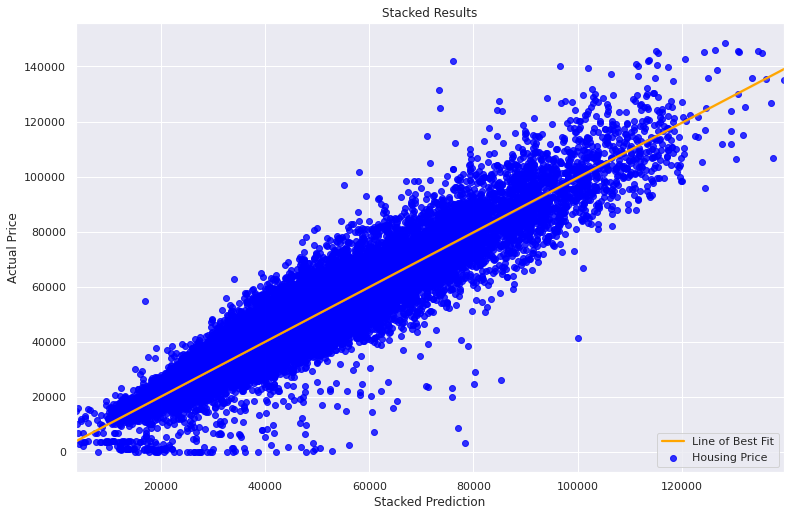

In [63]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(pred_y,test_y,color = 'blue',line_kws={'color':'orange'})#,hue='y_test')

ax.set(xlabel="Stacked Prediction", ylabel = "Actual Price",title = "Stacked Results")
ax.legend(['Line of Best Fit', 'Housing Price'], loc='lower right')

It is clear from the above figure that both prices are directly proportional. So the predicted results are good for the training data.

In [64]:
%%time
# Stacked Model Training For Test Data

# Model 1
r1 = xgb.XGBRegressor(objective ='reg:squarederror', min_child_weight = 2, subsample = 1,
                          colsample_bytree = 0.8,
                          learning_rate = 0.2, n_estimators = 500,
                         reg_lambda = 0.45, reg_alpha = 0, gamma = 0.5)
# Model 2
r2 = lgb.LGBMRegressor(objective='regression',num_leaves=36,learning_rate=0.15,
                        n_estimators=64,min_child_weight = 2, colsample_bytree = 0.8,
                        reg_lambda = 0.45)
# Model 3
r3 = RandomForestRegressor(random_state=42,n_estimators=900,max_depth=20,
                                              n_jobs=-1,min_samples_split=10,)

# Making Stacked Model
estimators = [('xgb', r1),('lgb', r2)]
sreg = StackingRegressor(estimators=estimators,final_estimator = r3)
                         

# Fitting the Model
sreg.fit(X_train, y_train)

# Predicting the Model
y_pred = sreg.predict(X_test)

# Evaluation
print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( y_pred, y_test))))


RMSLE 0.30326
CPU times: user 23min 1s, sys: 1.85 s, total: 23min 3s
Wall time: 5min 53s


### The error is very low (0.303), it means the algorithm is not working badly. We can ensure the results through visualization

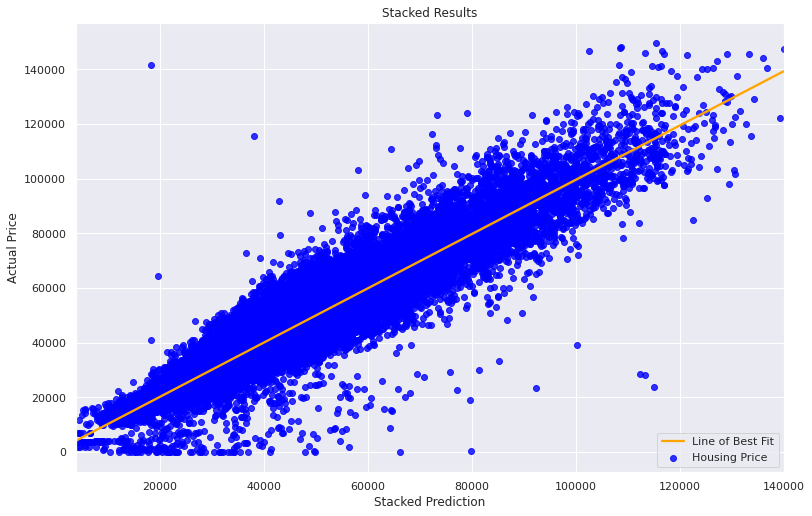

In [65]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(y_pred,y_test,color = 'blue',line_kws={'color':'orange'})#,hue='y_test')

ax.set(xlabel="Stacked Prediction", ylabel = "Actual Price",title = "Stacked Results")
ax.legend(['Line of Best Fit', 'Housing Price'], loc='lower right')

### It is clear from the above figure that both prices are directly proportional. So the predicted results are good for the test data.

# 3. Results

## RMSLE

| Model | Train Set | Test Set |
| --- | --- | --- |
| Random Forest | 0.292 | 0.302 |
| Light GBM | 0.297 | 0.308 |
| XG Boost  | 0.291 | 0.302 |
| Hybrid Regression   | 0.291 | 0.302 |
| Stacked Generalization | 0.293 | 0.303 |

## 3.1 Results Explanation

### The difference among each algorithm is very minor. Results are more or less the same.

### XG Boost and Hybrid Regression results are the better for both Train as well as Test Sets.

### Train Set is showing less error as compared to test set, which we can take as some overfitting to some extent.

## 3.2 Results Comparison witht the Researcher Work

### The researcher models are showing almost the same results among them but with less error as compared to our results

### Their minimum Train Set error is 0.13 while we reach at 0.29

### Similarly for Test Set error is 0.16 while our is showing 0.30 

## 3.3 Reasons For Different Results

### We fetched the data from Kaggle source which has more bugs.
### We deleted all the missing values as did by the researcher. But if we replace with appropriate values, then no data will be lost and there is more chance to acquire better results.

# 4. Recommendations

### After replicating the paper, we can improve our results by doing more exploratory analysis.

### We can also apply for estimating any housing price of different cities by keeping in mind the relevant data and the methodology applied in the paper.

### Rough Work
def score_func(y_true, y_pred, **kwargs):
    y_true = np.abs(y_true)
    y_pred = np.abs(y_pred)

    return np.sqrt(mean_squared_log_error(y_true, y_pred))
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = {'n_estimators':[i for i in range(100,300,100)],'max_depth':[i for i in range(0,4,2)],
              'min_samples_split':[i for i in range(2, 4)],'random_state': [42]}
scorer = make_scorer(score_func)
rf = RandomForestRegressor()
search = GridSearchCV(rf, parameters)#,scoring=scorer)
result = search.fit(X_train, y_train.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
sorted(clf.cv_results_.keys())
scorer = make_scorer(rmsle, greater_is_better=False, size=10)
grid = GridSearchCV(est, param_grid, scoring=scorer)

from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[i for i in range(100,1100,100)],'max_depth':[i for i in range(1,21,2)],
              'min_samples_split':[i for i in range(2, 12)],'random_state': [42]}

rf = RandomForestRegressor()

#search = GridSearchCV(rf, parameter, scoring='accuracy', n_jobs=-1, cv=cv)
clf = GridSearchCV(rf, parameters)
clf.fit(X_train, y_train.ravel())
sorted(clf.cv_results_.keys())